# Анализ графиков

In [71]:
%load_ext autoreload
%autoreload 2

import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
path_list = os.getcwd().split('\\')
if path_list[-1] == 'src':
    print(os.getcwd())
else:
    os.chdir('..')
    print(os.getcwd())

F:\study\Hackatons\DashboardSber\src


In [73]:
import pandas as pd
import numpy as np
from datetime import datetime
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()



#Plotting libraries
import altair as alt
# plt.style.use('seaborn-white')
%matplotlib inline

#statistics libraries
import statsmodels.api as sm
import scipy
from scipy.stats import anderson
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
from statsmodels.tsa.statespace.tools import diff as diff
import pmdarima as pm
from pmdarima import ARIMA, auto_arima
from scipy import signal
from scipy.stats import shapiro
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
import ruptures as rpt


import warnings
warnings.filterwarnings("ignore")
np.random.seed(786)

# Загрузка данных

In [74]:
def fix_date_columns(df):
    new_columns = [df.columns[0]]
    for column in df.columns[1:]:
        date = datetime.fromordinal(datetime(1900, 1, 1).toordinal() + int(column) - 2).strftime('%Y-%m-%d')
        new_columns.append(date)

    df.columns = new_columns
    return df


df_acquiring = pd.read_excel(
    io='dataset/acquiring.xlsb',
    engine='pyxlsb',
    header=1,  # У файла есть заголовок-объединение
    # nrows=1000,
)
df_acquiring = fix_date_columns(df_acquiring)

# df_rko = pd.read_excel(
#     io='dataset/rko.xlsb',
#     engine='pyxlsb',
#     header=1,  # У файла есть заголовок-объединение
# )
# df_rko = fix_date_columns(df_rko)

# df_economy_acquiring = pd.read_excel(
#     io='dataset/economy_acquiring.xlsb',
#     engine='pyxlsb',
#     header=1,  # У файла есть заголовок-объединение
# )

# df_economy_general = pd.read_excel(
#     io='dataset/economy_general.xlsb',
#     engine='pyxlsb',
#     header=1,  # У файла есть заголовок-объединение
# )

df_general = pd.read_excel(
    io='dataset/general.xlsb',
    engine='pyxlsb',
    header=0,  # У файла есть заголовок-объединение
)
df_general['Кластер'] = df_general['Кластер'].astype('category')

In [75]:
tmp_cols = ['клиент', 'Сегмент id', 'Кластер', 'Средний возраст работников', 'Тип организации']
df_acquiring_merged = pd.merge(df_general[tmp_cols], df_acquiring,  on='клиент', how='outer')

# Строим графики

In [76]:
series_cols = df_acquiring.columns[df_acquiring.columns.str.contains("клиент")==False].values
level_cols = df_acquiring.columns[df_acquiring.columns.str.contains("клиент")].values

In [77]:
def customer_churn_share(df: pd.DataFrame, end_id_month: int) -> float:
    """Доля оттока клиентов."""
    have_clients = df.iloc[:, end_id_month - 1]
    have_clients = have_clients[have_clients == 1]

    not_have_clients = df.iloc[have_clients.index, end_id_month]
    not_have_clients = not_have_clients[not_have_clients == 0]

    value = not_have_clients.shape[0] / have_clients.shape[0] * 100
    return value


customer_churn_share(df_acquiring, 2)

3.225806451612903

In [78]:
def customer_survival_rate(df: pd.DataFrame, end_id_month: int) -> float:
    """Расчет процента выживаемости клиентов"""
    start_clients = df.iloc[:, end_id_month - 1]
    start_clients = start_clients[start_clients == 1]

    left_clients = df.iloc[start_clients.index, end_id_month]
    left_clients = left_clients[left_clients == 0]

    df_copy = df.copy()
    df_copy = df_copy.drop(start_clients.index, axis=0)
    new_clients = df_copy.iloc[:, end_id_month]
    new_clients = new_clients[new_clients == 1]

    end_clients = start_clients.shape[0] - left_clients.shape[0] + new_clients.shape[0]
    value = ((end_clients - new_clients.shape[0]) / start_clients.shape[0]) * 100
    return value


customer_survival_rate(df_acquiring, 2)

96.7741935483871

In [79]:
series_cols = df_acquiring.columns[df_acquiring.columns.str.contains("клиент")==False].values

In [102]:
lst_customer_churn_share = [customer_churn_share(df_acquiring, i) for i in range(2, len(series_cols) + 1)]
lst_customer_survival_rate = [customer_survival_rate(df_acquiring, i) for i in range(2, len(series_cols) + 1)]

df_cr_pr = pd.DataFrame(series_cols[1:], columns=["ds"])
df_cr_pr['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d')
df_cr_pr.loc[:, "cr"] = lst_customer_churn_share
df_cr_pr.loc[:, "pr"] = lst_customer_survival_rate
df_cr_pr.head()

,ds,cr,pr
0,2021-10-31,3.225806,96.774194
1,2021-11-30,1.104972,98.895028
2,2021-12-31,1.104972,98.895028
3,2022-01-31,1.648352,98.351648
4,2022-02-28,1.111111,98.888889


In [109]:
data = pd.DataFrame(series_cols[len(series_cols)-df_cr_pr.shape[0]:], columns=["ds"])
data['ds'] = pd.to_datetime(data['ds'], format='%Y-%m-%d')

# data.loc[:, "y"] = df_acquiring[series_cols].sum().values
data.loc[:, "y"] = df_cr_pr.cr
# data.loc[:, "y"] = df_cr_pr.pr

data = data.set_index('ds')

print(data.shape)
data.tail()

(23, 1)


,y
ds,
2023-05-31,1.136179
2023-06-30,0.684053
2023-07-31,0.534896
2023-08-31,1.107670
2023-09-30,1.268946


## Рост пользователей за периоды

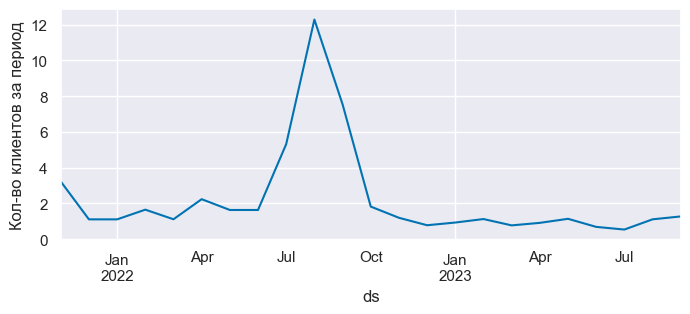

In [110]:
sns.set_palette("colorblind")

fig, ax = plt.subplots(1,1,figsize=(8,3))
data.y.plot(ax=ax)
ax.set_title("")
ax.set_ylabel("Кол-во клиентов за период");

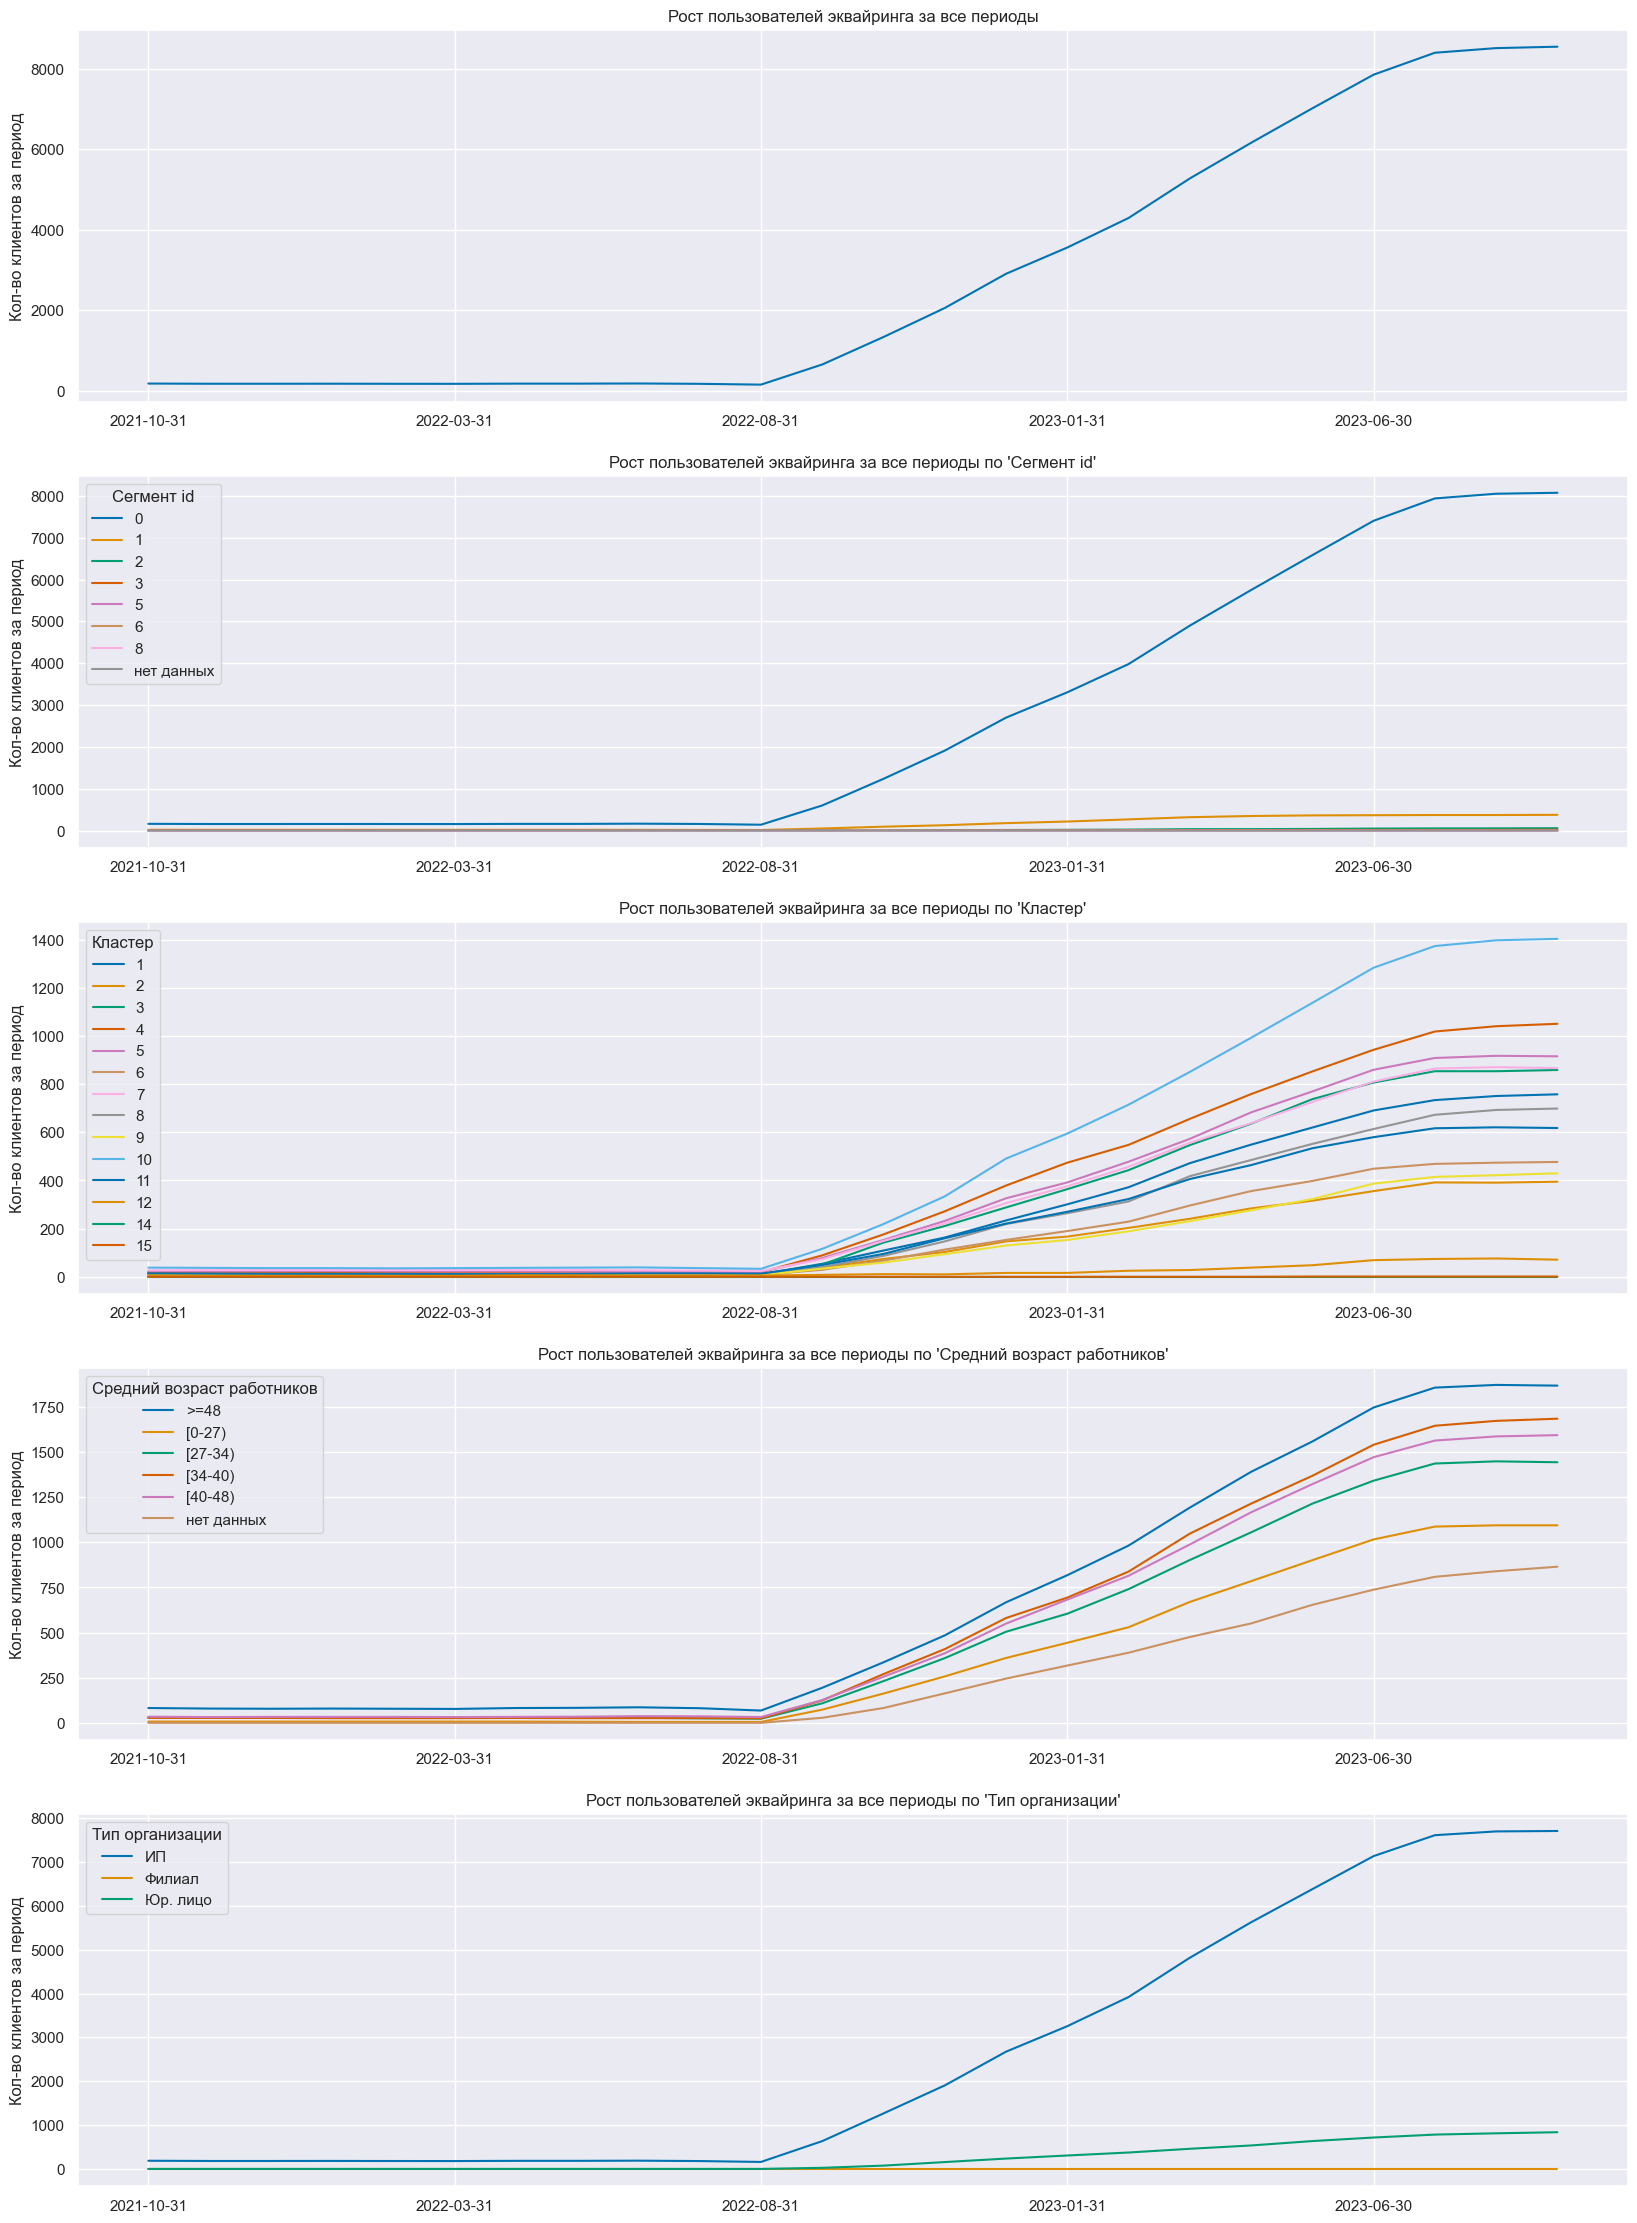

In [104]:
sns.set_palette("colorblind")

fig, ax = plt.subplots(5,1,figsize=(20,28))
df_acquiring_merged[series_cols].sum().plot(ax=ax[0])
ax[0].set_title("Рост пользователей эквайринга за все периоды")
ax[0].set_ylabel("Кол-во клиентов за период");

df_acquiring_merged.groupby("Сегмент id")[series_cols].sum().transpose().plot(ax=ax[1])
ax[1].set_title("Рост пользователей эквайринга за все периоды по 'Сегмент id'");
ax[1].set_ylabel("Кол-во клиентов за период");

df_acquiring_merged.groupby("Кластер")[series_cols].sum().transpose().plot(ax=ax[2])
ax[2].set_title("Рост пользователей эквайринга за все периоды по 'Кластер'")
ax[2].set_ylabel("Кол-во клиентов за период");

df_acquiring_merged.groupby("Средний возраст работников")[series_cols].sum().transpose().plot(ax=ax[3])
ax[3].set_title("Рост пользователей эквайринга за все периоды по 'Средний возраст работников'")
ax[3].set_ylabel("Кол-во клиентов за период");

df_acquiring_merged.groupby("Тип организации")[series_cols].sum().transpose().plot(ax=ax[4])
ax[4].set_title("Рост пользователей эквайринга за все периоды по 'Тип организации'")
ax[4].set_ylabel("Кол-во клиентов за период");

##

In [ ]:
# Вся теория здесь:
# https://pawarbi.github.io/blog/forecasting/r/python/rpy2/altair/2020/04/21/timeseries-part1.html

In [41]:
alt.Chart(data.reset_index()).mark_line(point=True).encode(
    x='ds', 
    y='y',
    column='year(ds)',
    tooltip=['ds', 'y']).properties(
    title="Рост клиентов за каждый год по отдельности",
    width=100).configure_header(
    titleColor='black',
    titleFontSize=14,
    labelColor='blue',
    labelFontSize=14
)

alt.Chart(...)

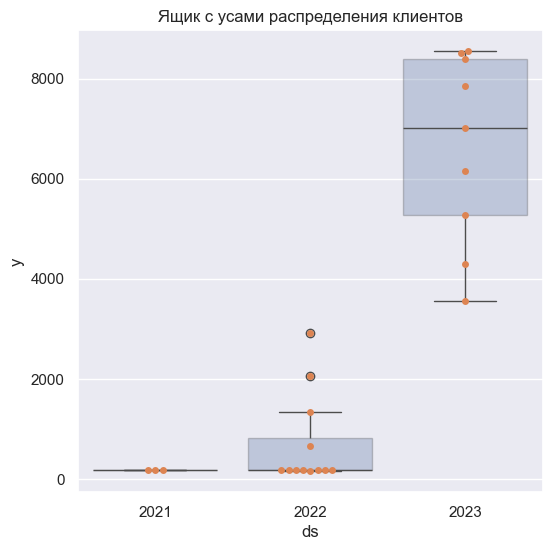

In [44]:
fig, ax = plt.subplots(figsize = (6, 6))
plt.title('Ящик с усами распределения клиентов')
sns.boxplot(data=data, x=data.index.year, y='y',  ax = ax, boxprops=dict(alpha=.3));
sns.swarmplot(data=data, x=data.index.year, y='y');

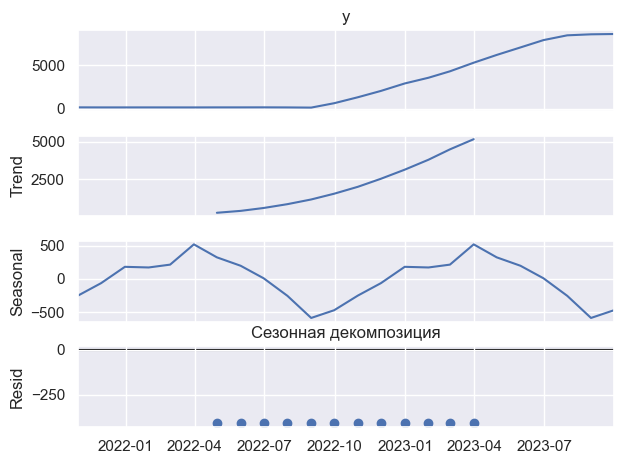

In [45]:
decompose = seasonal_decompose(data["y"])
decompose.plot();
plt.title('Сезонная декомпозиция')
plt.rcParams['figure.figsize'] = (12, 8);

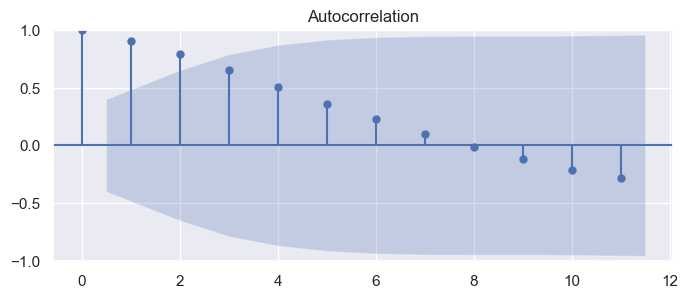

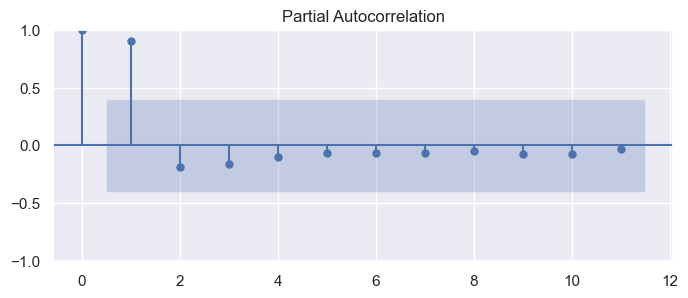

In [50]:
plot_acf(data, lags=11);
plot_pacf(data, lags=11);
plt.rcParams['figure.figsize'] = (8, 3);

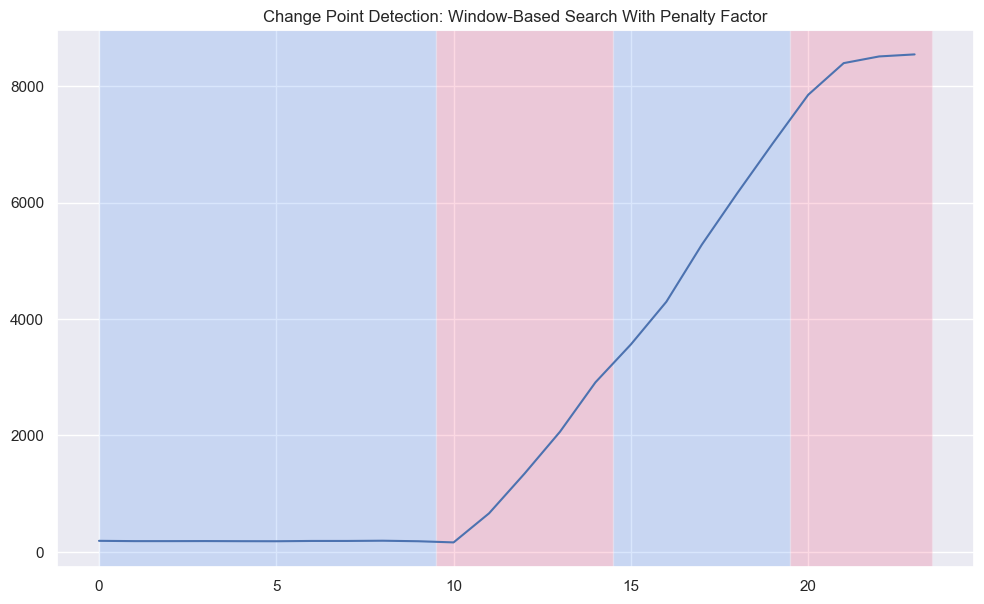

In [61]:
# Про этот график здесь: https://datastud.dev/posts/time-series-eda

points = np.array(data.y)

algo = rpt.Pelt(model="l2").fit(points)
result = algo.predict(pen=10)

rpt.show.display(points, result, figsize=(10, 6))
plt.title('Обнаружение точки изменения')
plt.show()

Проверка на нормальность распределения

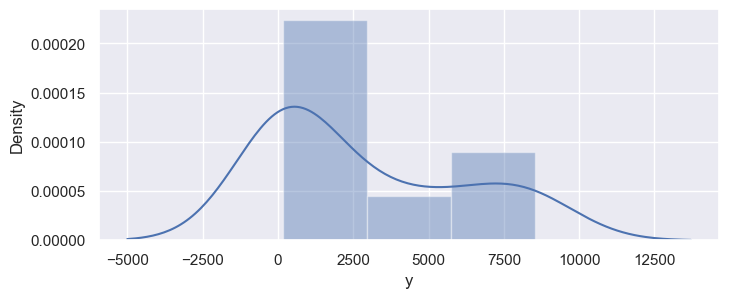

In [62]:
sns.distplot(data["y"]);

In [70]:
from scipy.stats import jarque_bera as jb

is_norm = jb(data["y"])[1]
print(f"p value:{is_norm.round(2)}", ", Series is Normal" if is_norm >0.05 else ", Series is Non-Normal")

p value:0.19 , Series is Normal
